# This is the hardest and the longest part of the code. It takes in the distribution of costs and quality and solves for the quilibrium numerically.

In [1]:
print("listing package versions... ")
import sys
print("python:", sys.version)
import pickle as pkl
import seaborn as sns
print("seaborn:", sns.__version__)
import matplotlib as mpl
import matplotlib.pyplot as plt
print("matplotlib:", mpl.__version__)
import numpy as np
print("numpy:", np.__version__)
import numba as nb
print("numba:", nb.__version__)
import scipy as sp
import scipy.integrate as sp1
import scipy.interpolate as sp2
import scipy.misc as sp3
import scipy.optimize as sp4
print("scipy:", sp.__version__)
import os
from pathlib import Path
%matplotlib inline

listing package versions... 
python: 3.7.0 (default, Jun 28 2018, 07:39:16) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
seaborn: 0.9.0
matplotlib: 2.2.3
numpy: 1.15.1
numba: 0.39.0
scipy: 1.1.0


In [2]:
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = 8,8

sns.set_context("paper")
sns.set(font='serif')
sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]})

pardir=Path(os.getcwd()).parent.parent
datadir=str(pardir) +'/Data'

mycmap=sns.cubehelix_palette(n_colors=50, start=1, rot=4, light=0.7, dark=0)

In [3]:
# my homebrew 2d interpolation function
@nb.autojit(nopython=True)
def int2d(x,y,matrix):
    a,b=matrix.shape
    left=np.int(min(max(np.int(x),0),a-2))
    right=left+1
    bottom=np.int(min(max(np.int(y),0),b-2))
    top=bottom+1
    x=right-x
    y=top-y
    return x*y*matrix[left,bottom]+(1-x)*y*matrix[right,bottom]+x*(1-y)*matrix[left,top]+(1-x)*(1-y)*matrix[right,top]

# this copy to pass into the integrator (scipy won't take the raw function)
@nb.autojit()
def int2dslow(x,y,matrix):
    a,b=matrix.shape
    left=np.int(min(max(np.int(x),0),a-2))
    right=left+1
    bottom=np.int(min(max(np.int(y),0),b-2))
    top=bottom+1
    x=right-x
    y=top-y
    return x*y*matrix[left,bottom]+(1-x)*y*matrix[right,bottom]+x*(1-y)*matrix[left,top]+(1-x)*(1-y)*matrix[right,top]

In [4]:
# This creates the distribution of theta and alpha
@nb.autojit(nopython=True)
def create7Lin(reflect6,reflect7,fc,right,w,scale): 
    for i in range(0,100*fc+1):
        for j in range(i,min(i+right-100*fc,right)):
            bid=(1-w)*(j-i)/w
            if bid<100*fc+1 and bid>-1:
                reflect7[i,j]=int2d(i,bid,reflect6)

# @nb.autojit(nopython=True)
# def create7LogLin(reflect6,reflect7,fc,right,w,scale): 
#     for i in range(0,100*fc+1):
#         for j in range(i,right):
#             iloc=i/(fc*scale)
#             jloc=j/(fc*scale)
#             aq=iloc-100
#             th=jloc-100
#             q=np.power(-(100)/aq,1/w)
#             rmc=-100*(jloc-iloc)/aq
#             jac=q*100/(w*aq*aq)
#             reflect7[i,j]=int2d(q*fc,rmc*fc,reflect6)*jac

In [5]:
# compute the dF/dtheta
@nb.autojit(nopython=True)
def create1(Fp1,right,fc): 
    for j in range(0,right):
        for i in range(0,100*fc):
            Fp1[i+1,j]+=Fp1[i,j]

# compute the dF/dsigma
@nb.autojit(nopython=True)
def create2(Fp2,right,fc): 
    for i in range(0,100*fc+1):
        for j in range(0,right-1):
            Fp2[i,j+1]+=Fp2[i,j]

# compute the F
@nb.autojit(nopython=True)
def create0(F,right,fc): 
    for i in range(0,100*fc+1):
        for j in range(0,right-1):
            F[i,j+1]+=F[i,j]

# compute the Z function that captures participation
@nb.autojit(nopython=True)
def createZ(Z,F,right,freq,powr,fc): 
    FF=F/np.max(F)
    for i in range(0,100*fc+1):
        for j in range(0,right):
            num=0
            den=0
            for k in range(0,len(powr)):
                num+=np.power(FF[i,j],powr[k]-2)*freq[k]
                den+=np.power(FF[i,j],powr[k]-2)*freq[k]*(powr[k]-1)
            Z[i,j]=num/den

# compute the right handside of the ODE
@nb.autojit(nopython=True)
def create3(Z,F,Fp1,Fp2,rhs,rhsfake,right,fc): 
    for i in range(0,100*fc+1):
        for j in range(i+1,right):
            den=-Fp2[i,j]+Z[i,j]*F[i,j]/(j-i)
            if den!=0:
                my=Fp1[i,j]/den
                if my>0:
                    rhs[i,j]=my
                    rhsfake[i,j]=1
            rhs[0,0]=1/2
            rhs[0,1]=1/2

# compute the distribution of the pseudo-type
@nb.autojit(nopython=True)
def create8(reflect7,reflect8,myinv,myfor,F,xmax,ymax,fc,right): 
    for i in range(0,100*fc+1):
        myright=right#min(i+int(round(100*fc*ww)),right)
        for j in range(i,myright):
            if i<ymax:
                if j<xmax:
                    inv=myinv[i]
                    if inv>=j:
                        reflect8[i,j]=F[i,inv]
                    else:
                        reflect8[i,j]=F[myfor[j],j]
                else:
                    reflect8[i,j]=F[100*fc,j]
            else:
                reflect8[i,j]=F[i,right-1]
                
# compute the residual distribution of the pseudo-type
@nb.autojit(nopython=True)
def create9(reflect8,reflect9, l, powers, frequencies, right, fc): 
    for k in range(0,l):
        pk=powers[k]-1
        fk=frequencies[k]
        for i in range(0,100*fc+1):
            myright=right#i+int(round(100*fc*ww))
            for j in range(i,myright):
                reflect9[i,j]+=(reflect8[i,j]**pk)*fk

# This is just to speed up the calculation of certain constants for interim quality and rebate
@nb.autojit(nopython=True)
def myhelpLin(rrr, qqq, fc, ww): 
    for i in range(0,100*fc+1):
        myright=i+int(round(100*fc*ww))
        for j in range(i,myright):
            qqq[i,j]=i/fc
            rrr[i,j]=1/(ww*fc)
            
# @nb.autojit(nopython=True)
# def myhelpLogLin(rrr, qqq, fc, scale,w): 
#     for i in range(0,100*fc+1):
#         iloc=i/(fc*scale)
#         aq=iloc-100
#         q=np.power(-(100)/aq,1/w)
#         for j in range(0,right):
#             rrr[i,j]=np.power(q,w)/(fc*scale)
#             qqq[i,j]=q 
          
#Here I compute the interim rebate (modulus some constant)
@nb.autojit(nopython=True)
def createR(reflect9,reflect9help,rebate,myinv,right,fc): 
    end=min(100*fc+1,len(myinv))
    for i in range(0,end):
        myright=right
        for j in range(i,myright-1):
            reflect9help[i,j+1]+=reflect9help[i,j]
        for j in range(myinv[i],myright):
            rebate[i,j]=max((j-i)*reflect9[i,j]-reflect9help[i,j],0)

#Here I take expectation of quality and rebate
@nb.autojit(nopython=True)
def mymultiply(reflect9,rebate,quality): 
    mysum=np.sum(reflect9)
    EQ=np.sum(np.multiply(reflect9,quality))/mysum
    ER=np.sum(np.multiply(reflect9,rebate))/mysum
    return ER,EQ

In [6]:
design='linear'

industry="sci"
weight="80"

fc=8

mydir=datadir+"/derive/"+industry+weight+"/"
[PART,DATA]=pkl.load(open(datadir+'/derive/'+industry+weight+"j.pkl", "rb"))
dist_rmcq=pkl.load(open(mydir+industry+weight+"j_rcmq_"+str(fc)+".pkl", "rb"))

In [7]:
mpl.rcParams['figure.figsize'] = 8,8

# This is our joint distribution of (r-c, q)

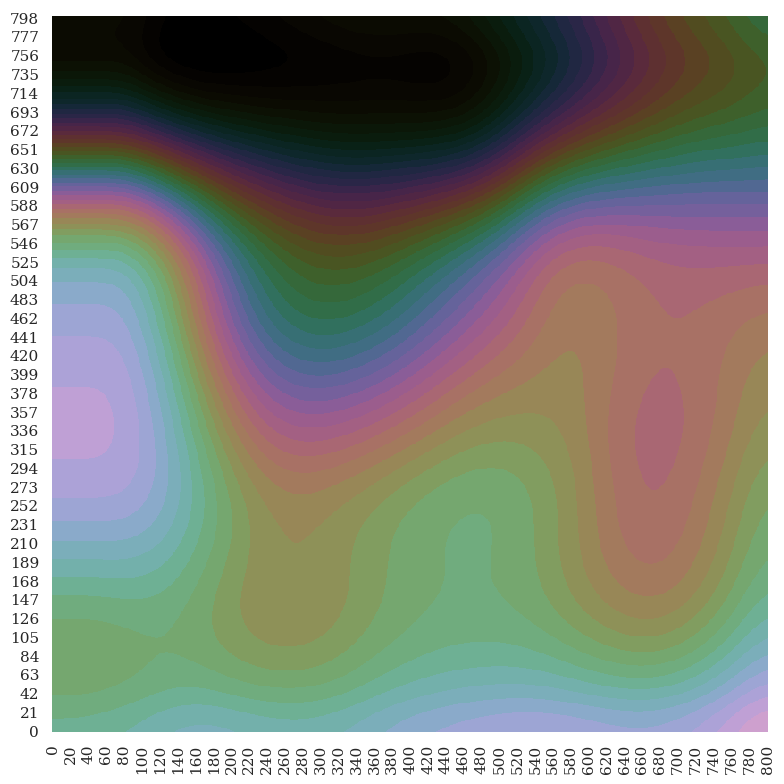

In [8]:
ax=sns.heatmap(dist_rmcq, cmap=mycmap, cbar=0, square=1)
ax.invert_yaxis()
plt.tight_layout()

In [9]:
powr=np.array(PART[0])
freq=np.array(PART[1])
freq=freq/np.sum(freq)

In [10]:
#fix the weight w between 10 and 1000.
w=550
w=w/1000

if design=='linear':
    ww=w/(1-w)
    scale=1/1-w
    right=int(100*fc/(1-w))+1
    dist_alth=np.zeros((100*fc+1,right),dtype=float)
    create7Lin(dist_rmcq,dist_alth,fc,right,w,scale)
# elif design=='loglinear':
#     scale=1/(1-(1/np.power(100,w)))        
#     right=int((100*fc)*scale)+1
#     dist_alth=np.zeros((100*fc+1,right),dtype=float)
#     create7LogLin(dist_rmcq,dist_alth,fc,right,w,scale)

# This is our distribution of (theta,alpha)

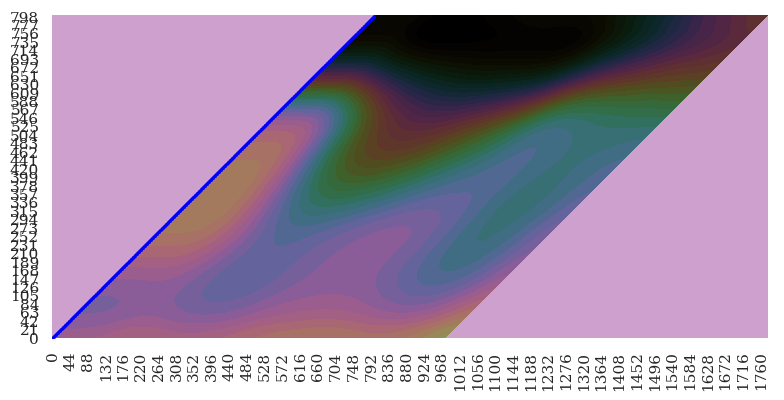

In [11]:
ax=sns.heatmap(dist_alth, cmap=mycmap, cbar=0, square=1)
ax.invert_yaxis()
plt.plot(range(0,100*fc+1),np.array(range(0,100*fc+1)), 'ro', markersize=1, color= 'blue')
plt.tight_layout()

In [23]:
Fp1=dist_alth.copy(); create1(Fp1,right,fc)
Fp2=dist_alth.copy(); create2(Fp2,right,fc)
F=Fp1.copy(); create0(F,right,fc)

Z=np.zeros((100*fc+1,right),dtype=float) 
createZ(Z,F,right,freq,powr,fc)
 
#rhsfake is just to plot the funnel    
rhsfake=np.zeros((100*fc+1,right),dtype=float)  
#rhs is what we need for the ODE
rhs=np.zeros((100*fc+1,right),dtype=float)
create3(Z,F,Fp1,Fp2,rhs,rhsfake,right,fc)   

In [22]:
#here I solve the ODE

mydic={}

def myfun(x,y):
    return int2dslow(y,x,rhs)

myode=sp1.ode(myfun, jac=None)
myode.set_initial_value(1*fc, 1*fc+1)
myode.set_integrator('dopri5', nsteps=5000)

dt=0.1
x=[1*fc,1*fc]
y=[1*fc+1,1*fc+1]

flag=0

while y[-1] < 100*fc+1 and x[-1] < right:
    newy=myode.integrate(myode.t+dt)[0]
    if newy-y[-1]>10*dt or (newy==y[-1] and y[-1]>2*fc):
        x=x+[x[-1]]
        y=y+[y[-1]+dt]
        myode.set_initial_value(y[-1], x[-1])
    else:
        x=x+[myode.t+dt]
        y=y+[newy]

mydic[int(round(1000*w))]=[np.array(x),np.array(y)]

# Always good to know how the funnel looks

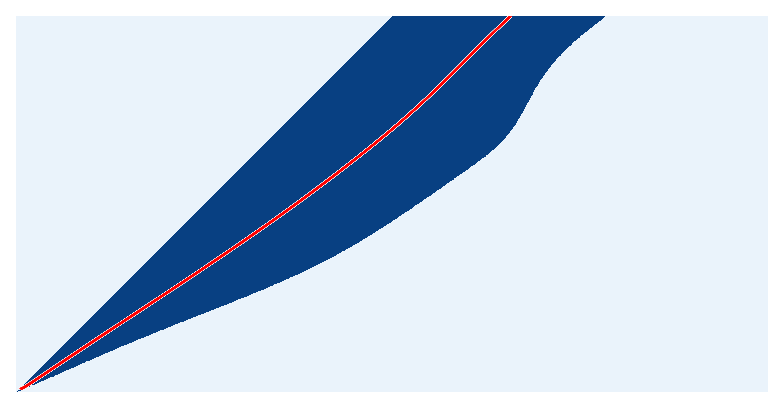

In [14]:
ax=sns.heatmap(rhsfake[:,:200*fc], cmap=sns.color_palette("Blues",15), cbar=0, square=1)
ax.invert_yaxis()
plt.plot(np.array(x), np.array(y), 'ro', markersize=1, color= 'white')
plt.plot(np.array(x), np.array(y), 'ro', markersize=0.1, color= 'red')

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.savefig(industry+weight+'_funnel.png', bbox_inches='tight')

In [15]:
fstrat = sp2.interp1d([0]+list(x),[0]+list(y))
fstrat_inv = sp2.interp1d([0]+list(y),[0]+list(x))

ymax=int(max(y))
#print('ymax=',ymax)

xmax=int(max(x))
#print('xmax=',xmax)

myinv=[]
for i in range(0,ymax):
    myinv+=[int(fstrat_inv(i))]
myinv=np.array(myinv)

myfor=[]
for i in range(0,xmax):
    myfor+=[int(fstrat(i))]
myfor=np.array(myfor)

In [16]:
#compute the distribution of pseudo-type
dist_pseudo=np.zeros((100*fc+1,right),dtype=float)

create8(dist_alth,dist_pseudo,myinv,myfor,F,xmax,ymax,fc,right)
dist_pseudo=dist_pseudo/np.max(dist_pseudo)

frequencies=np.array(PART[1])/np.sum(PART[1])
powers=np.array(PART[0])

l=len(powers)    

num=0
for i in range(0,len(powers)):
    num+=powers[i]*frequencies[i]
    
print('num=',num)

#compute the residual distribution of pseudo-type
dist_power=np.zeros((100*fc+1,right),dtype=float)

create9(dist_pseudo,dist_power, l ,powers, frequencies, right, fc)

num= 3.006172839506173


# This is the distribution of pseudo-type

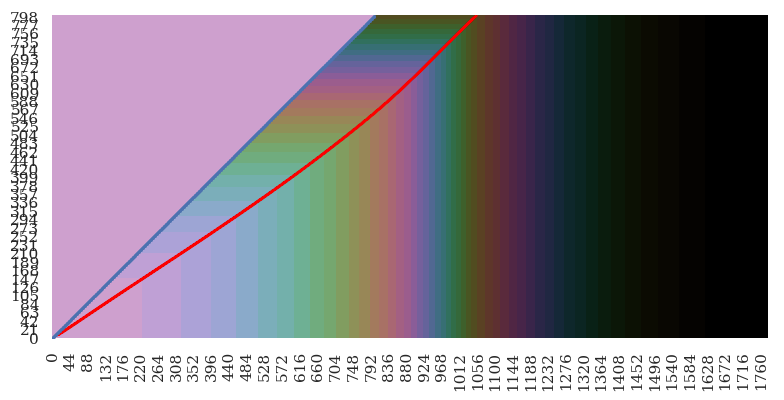

In [17]:
ax=sns.heatmap(dist_pseudo, cmap=mycmap, cbar=0, square=1)
ax.invert_yaxis()
plt.plot(np.array(x), np.array(y), 'ro', markersize=0.2, color= 'red')
plt.plot(range(0,100*fc+1),np.array(range(0,100*fc+1)), 'ro', markersize=1, color= 'b')
plt.tight_layout()

In [18]:
#here I compute interim rebate and quality
rrr=np.zeros((100*fc+1,right),dtype=float)      
qqq=np.zeros((100*fc+1,right),dtype=float)

if design=='linear':
    myhelpLin(rrr, qqq, fc, ww)
if design=='loglinear':
    myhelpLogLin(rrr, qqq, fc, scale,w)

quality=np.multiply(dist_power,qqq)

rebate=np.zeros((100*fc+1,right),dtype=float)

dist_power_help=dist_power.copy()

#sys.stdout.write('create R, ')
createR(dist_power,dist_power_help,rebate,myinv,right,fc)
rebate=np.multiply(rebate,rrr)
# print(np.min(rebate),np.max(rebate))

# This is interim quality

99.99999999999997


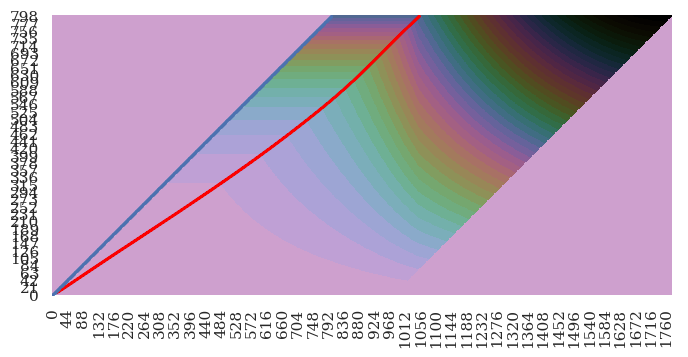

In [19]:
ax=sns.heatmap(quality, cmap=mycmap, cbar=0, square=1)
plt.plot(np.array(x), np.array(y), 'ro', markersize=0.2, color= 'red')
plt.plot(range(0,100*fc+1),np.array(range(0,100*fc+1)), 'ro', markersize=1, color= 'b')
ax.invert_yaxis()
print(np.max(quality))

# This is interim rebate

46.723262743667284


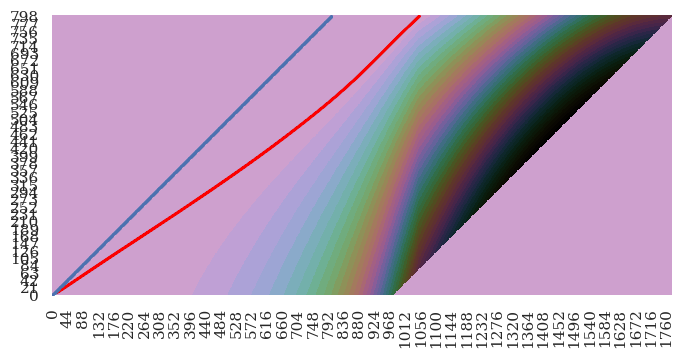

In [20]:
ax=sns.heatmap(rebate, cmap=mycmap, cbar=0, square=1)
plt.plot(np.array(x), np.array(y), 'ro', markersize=0.2, color= 'red')
plt.plot(range(0,100*fc+1),np.array(range(0,100*fc+1)), 'ro', markersize=1, color= 'b')
ax.invert_yaxis()
print(np.max(rebate))

# Finally expected rebate and expected quality

In [21]:
ER,EQ=mymultiply(dist_alth,rebate,quality)
print('\n w=',w,':',num*ER,num*EQ)


 w= 0.55 : 34.98896936758641 85.21765993569944
